In [1]:
# data from: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset/code
# reference: https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1 
# reference: https://github.com/Alexiush/weak-causality-and-causal-disposition-in-images/blob/main/ca_cnn_sample_resnet.ipynb

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pathlib

In [2]:
data_train = pathlib.Path('./Dataset/train')
data_test = pathlib.Path('./Dataset/test')

INPUT_SIZE = [300, 300]
BATCH = 6

In [3]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.0,
    rescale=1./255
    )

training_data = training_datagen.flow_from_directory('./Dataset/train', 
                                                     subset="training", 
                                                     shuffle=True, 
                                                     target_size=INPUT_SIZE, 
                                                     batch_size=BATCH, 
                                                     color_mode="rgb",
                                                     # interpolation="bilinear", 
                                                     class_mode='categorical')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory('./Dataset/test', 
                                             target_size=INPUT_SIZE, 
                                             color_mode="rgb", 
                                             batch_size=BATCH,
                                             class_mode='categorical',
                                             shuffle=False)

x_test, y_test = next(test_data)
x_train, y_train = next(training_data)

Found 1956 images belonging to 5 classes.
Found 330 images belonging to 5 classes.


In [4]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#Precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#F1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 5*((precision*recall)/(precision+recall+K.epsilon()))

#Especificidad
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [5]:
vgg_model = tf.keras.applications.VGG16(input_shape=(300, 300, 3), weights=None, include_top=False) # weights='imagenet'
for layer in vgg_model.layers:
    layer.trainable = False
# vgg_model.trainable = True
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
#     tf.keras.layers.InputLayer(shape=(300, 300, 3)),
#     vgg_model,
#     GlobalAveragePooling2D(),
#     Flatten(),
#     Dense(5, activation='softmax')])
# 
# model.summary()

# from tensorflow.keras import Model
# flatten = Flatten()(vgg_model.output)
# dense_1 = Dense(units=500, activation='relu')(flatten)
# dense_2 = Dense(units=500, activation='relu')(dense_1)
# dense_3 = Dense(units=100, activation='relu')(dense_2)
# dense_4 = Dense(units=100, activation='relu')(dense_3)
# dense_output = Dense(units=5, activation='softmax')(dense_4)
# model = Model(inputs=vgg_model.input, outputs=dense_output)
# model.summary()

resn_model = tf.keras.applications.ResNet101V2(input_shape=(300, 300,3), include_top=False, weights=None)
resn_model.trainable = True

fine_tune_at = 100
for layer in resn_model.layers[:fine_tune_at]:
    layer.trainable =  False

model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
    tf.keras.layers.InputLayer((300, 300, 3)),
    resn_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(5, activation='softmax')])

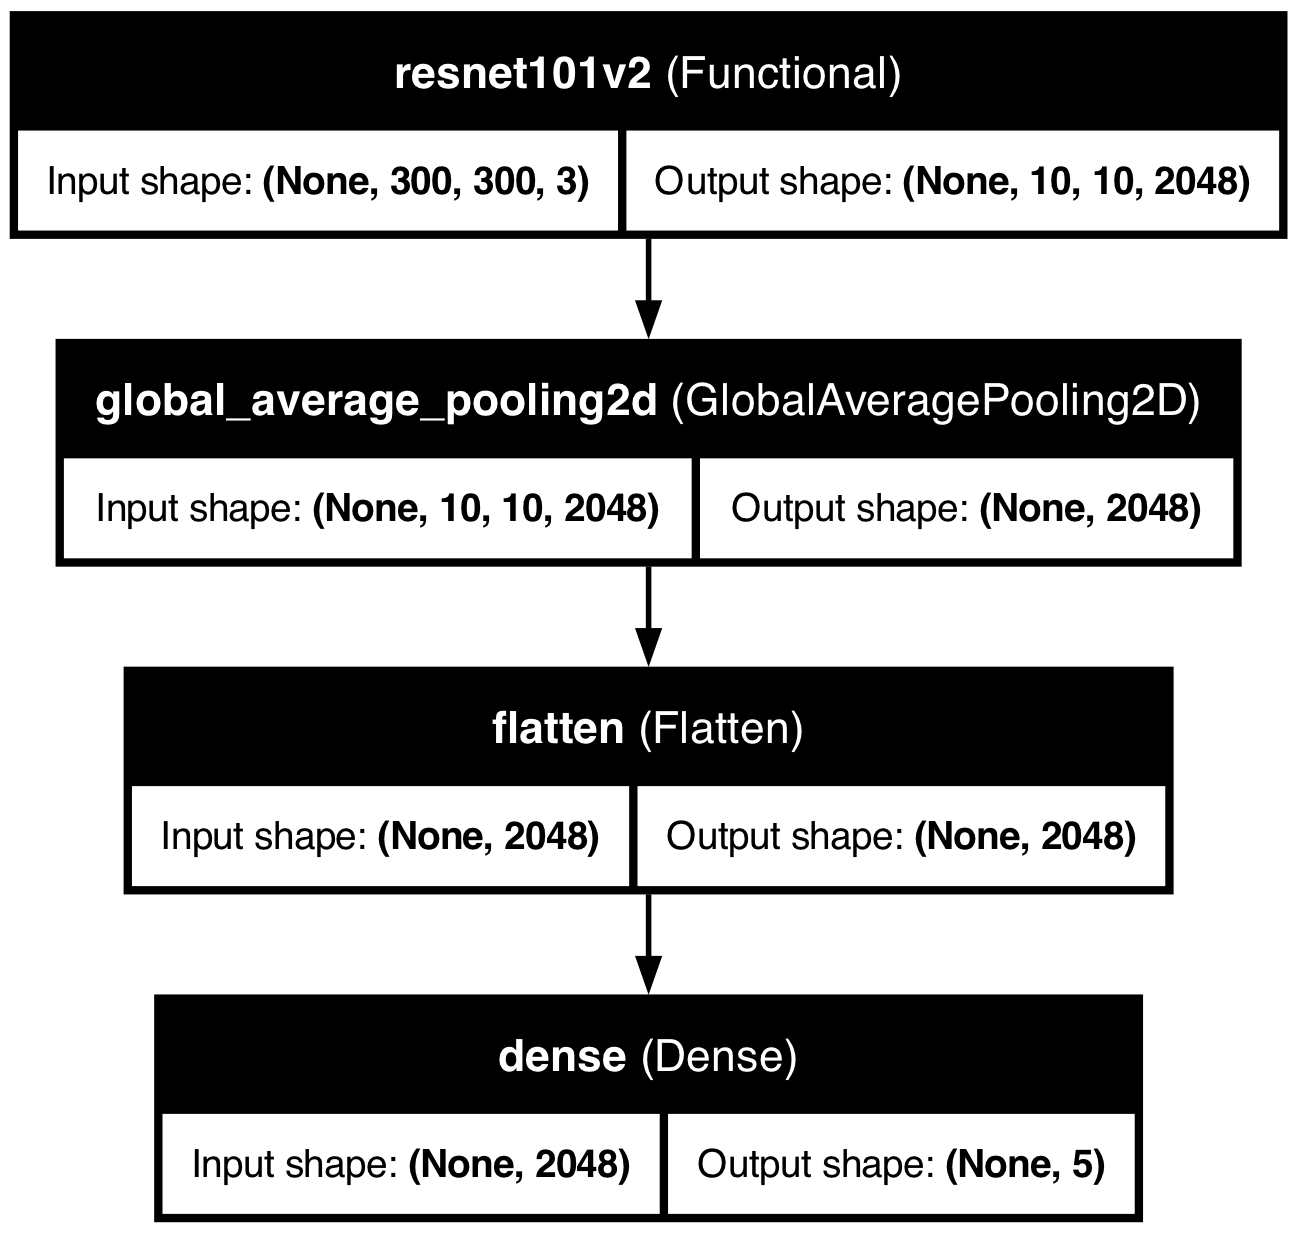

In [7]:
import tensorflow as tf
import pydot

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


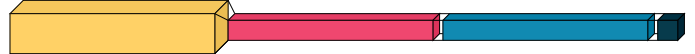

In [8]:
import visualkeras
visualkeras.layered_view(model)

In [9]:
# model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
#               loss='categorical_crossentropy',
#               metrics=['accuracy', specificity, precision_m, recall_m],
#               )
# 
# print(model.summary())

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)
#  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)

history = model.fit(
    training_data,
    validation_data=test_data,
    epochs=10,
    # batch_size=BATCH,
    # steps_per_epoch=len(training_data),
    # validation_steps=len(test_data)
)

Epoch 1/10


/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


326/326 ━━━━━━━━━━━━━━━━━━━━ 612s 2s/step - accuracy: 0.2745 - loss: 1.7830 - val_accuracy: 0.2939 - val_loss: 1.5259
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.3298 - loss: 1.5063 - val_accuracy: 0.3939 - val_loss: 4.9790
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.3748 - loss: 1.4575 - val_accuracy: 0.3545 - val_loss: 4.0316
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.3732 - loss: 1.4358 - val_accuracy: 0.2515 - val_loss: 2.0271
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.4234 - loss: 1.3992 - val_accuracy: 0.4152 - val_loss: 1.3665
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.4320 - loss: 1.3642 - val_accuracy: 0.4242 - val_loss: 1.9602
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.4722 - loss: 1.3201 - val_accuracy: 0.3697 - val_loss: 1.6186
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.4974 - loss: 1.2488 - val_accuracy: 0.409

In [15]:
#Creacion de la matriz de confusion
y_pred=model.predict(test_data, batch_size=BATCH)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm=confusion_matrix(test_data.classes, y_pred)
print(cm)

#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)

#Reporte de metricas
# target_names = ['KN95', 'N95', 'Generico', 'Quirurgico', 'Sin_cubrebocas']
# print(classification_report(test_data.classes, y_pred, target_names=target_names, digits=4))

# loss, accuracy, specificity, precision, recall = model.evaluate(test_data, verbose=0)
loss, accuracy = model.evaluate(test_data, verbose=0)

print(loss, accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 621ms/step
(330, 5)
[0 3 2 0 3 0 0 0 3 0 0 0 0 0 0 3 0 2 0 0 0 2 0 0 2 0 3 4 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 2 3 0 3 2 0 0 0 0 0 0 0 0 3 0 3 0 0
 0 3 3 0 0 0 0 0 0 0 2 2 0 0 0 2 2 2 0 0 0 2 2 0 0 2 0 0 2 0 2 0 2 0 0 0 0
 0 0 2 2 3 2 0 0 2 3 0 0 0 0 2 4 2 2 0 4 2 2 2 2 2 3 2 2 2 2 2 2 0 2 3 2 3
 2 0 2 2 2 2 2 2 4 2 0 0 2 2 2 0 2 0 2 0 4 3 2 0 2 0 0 4 4 2 2 0 0 3 3 3 3
 0 3 3 3 3 2 0 2 0 3 3 3 3 2 3 3 3 3 3 0 0 2 3 3 0 3 0 3 3 3 3 0 3 4 3 0 3
 0 3 3 3 3 2 0 0 3 2 0 0 3 0 3 3 0 3 3 3 3 3 3 3 0 0 0 3 0 3 0 0 0 4 4 0 3
 2 4 4 3 4 4 4 0 4 0 0 4 4 0 4 0 0 4 0 0 0 4 0 4 3 4 3 0 4 0 0 0 0 0 2 0 4
 0 4 0 0 0 0 2 0 3 0 3 3 3 4 0 0 0 2 0 4 4 2 0 0 4 3 4 4 4 4 4 4 4 4]
[[59  0  6 11  2]
 [30  0 17  2  1]
 [11  0 29  4  5]
 [25  0  8 44  1]
 [31  0  5  9 30]]
[0.75641026 0.         0.59183673 0.56410256 0.4       ]
1.266706943511963 0.4909090995788574


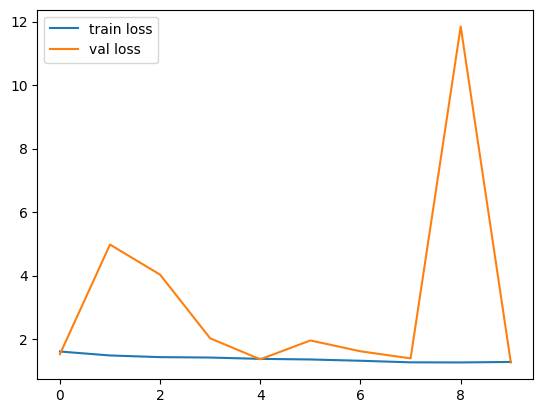

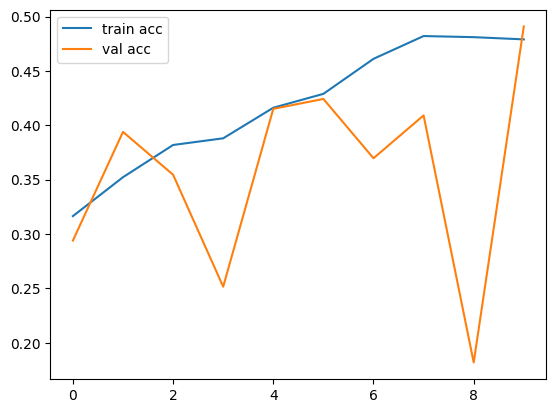

In [13]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

In [14]:
import numpy as np

test_image = tf.keras.preprocessing.image.load_img(
    './Dataset/test/cloth/1.jpg',
    target_size=INPUT_SIZE)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
i = np.argmax(result[0])
classes = training_data.class_indices.keys()
print(classes)
list(classes)[i]

# if result[0][0] < 0.5:
#     print('Image classified as WithMAsk')
# else:
#     print('Image classified as Without Mask')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
dict_keys(['cloth', 'n95', 'n95v', 'nfm', 'srg'])


'nfm'